<a href="https://colab.research.google.com/github/Ifeeding99/tensorflow-scripts/blob/main/twitter_classification_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 1.6 MB 41.6 MB/s 
     |████████████████████████████████| 5.8 MB 41.3 MB/s 
     |████████████████████████████████| 438 kB 56.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 22.6 MB/s 
     |████████████████████████████████| 596 kB 31.2 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 6.6 MB 43.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import files
f = files.upload()

Saving test.csv to test.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
new_texts = []
for s in train_df.tweet:
  #n_s = re.sub('[@Ã°ÂŸÂ™ÂŒÃ°ÂŸÂ˜Â‰Šð¦±!†]','', s)
  n_s = re.sub('[^A-Za-z-\s]','',s)
  new_texts.append(n_s)
train_df.tweet = new_texts
train_df.head()

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i cant use ca...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [ ]:
label_train = train_df.pop('label')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


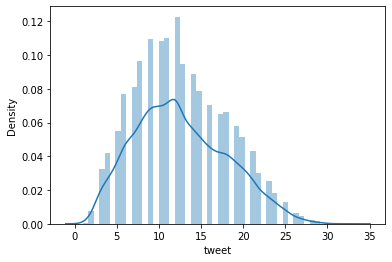

In [ ]:
len_texts = train_df.tweet.apply(lambda x: len(x.split()))
sns.distplot(len_texts)

In [ ]:
max_tweet_length = 30
checkpoint = 'bert-base-cased'
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
new_tweets_ids = np.zeros((train_df.shape[0], max_tweet_length), dtype = 'int32')
new_tweets_attention = np.zeros((train_df.shape[0], max_tweet_length), dtype = 'int32')
new_tweets_ids_type = np.zeros((train_df.shape[0], max_tweet_length), dtype = 'int32')
for i,el in enumerate(train_df.tweet):
  tokenized = tokenizer(el, max_length = max_tweet_length, padding = 'max_length', truncation = True, return_tensors = 'tf')
  new_tweets_ids[i,:], new_tweets_attention[i,:], new_tweets_ids_type[i,:] = tokenized['input_ids'], tokenized['attention_mask'], tokenized['token_type_ids']

In [ ]:
label_train = np.array(label_train)
import tensorflow as tf
label_train = tf.expand_dims(label_train, axis = 1)
new_tweets_ids = tf.expand_dims(new_tweets_ids, axis = 1)
new_tweets_attention = tf.expand_dims(new_tweets_attention, axis = 1)
new_tweets_ids_type = tf.expand_dims(new_tweets_ids_type, axis = 1)
train_dataset = tf.data.Dataset.from_tensor_slices((new_tweets_ids, new_tweets_attention, new_tweets_ids_type, label_train))

In [ ]:
def name_subsets(new_tweets_ids, new_tweets_attention, new_tweets_ids_type, label_train):
  return {'new_tweets_ids':new_tweets_ids, 'new_tweets_attention':new_tweets_attention, 'new_tweets_ids_type':new_tweets_ids_type},label_train

train_dataset = train_dataset.map(name_subsets)

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalMaxPool1D, Dense, Dropout, BatchNormalization

In [ ]:
tokenized = tokenizer('hello wordl!', max_length = max_tweet_length, padding = 'max_length', truncation = True, return_tensors = 'tf')
ids, att, type_ids = tokenized['input_ids'], tokenized['attention_mask'], tokenized['token_type_ids']
output = bert(ids, att)
output.logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.15999252,  0.2530749 ]], dtype=float32)>

In [ ]:
# model
input_ids = Input(shape=(max_tweet_length), name = 'new_tweets_ids', dtype = 'int32')
input_attention = Input(shape=(max_tweet_length), name = 'new_tweets_attention', dtype = 'int32')
input_ids_type = Input(shape=(max_tweet_length), name = 'new_tweets_ids_type', dtype = 'int32')


x = bert(input_ids, input_attention, input_ids_type)
x = x.logits
x = BatchNormalization()(x)
x = Dense(units = 256, activation = 'relu')(x)
x = Dense(units = 64, activation = 'relu')(x)
output_layer = Dense(units = 1, activation = 'sigmoid')(x)

model = Model(inputs=[input_ids, input_attention, input_ids_type], outputs = output_layer)

In [ ]:
model.layers[3].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 new_tweets_ids (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 new_tweets_attention (InputLay  [(None, 30)]        0           []                               
 er)                                                                                              
                                                                                                  
 new_tweets_ids_type (InputLaye  [(None, 30)]        0           []                               
 r)                                                                                               
                                                                                              

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
label_train

<tf.Tensor: shape=(31962, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])>

In [ ]:
model.fit(train_dataset,
          epochs = 10,
          batch_size = 32) # too much time and ram is needed

Epoch 1/10
  978/31962 [..............................] - ETA: 1:30:33 - loss: 0.5545 - accuracy: 0.9274

KeyboardInterrupt: ignored

In [ ]:
output = bert(new_tweets_ids[0], new_tweets_attention[0], new_tweets_ids_type[0])

In [ ]:
encoded = tokenizer('hello world!', max_length = max_tweet_length, truncation = True, padding = 'max_length', return_tensors = 'tf')
ids, att = encoded['input_ids'], encoded['attention_mask']
output = bert(ids, att)
output.logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.2937234 , -0.27665117]], dtype=float32)>

In [ ]:
print(ids)
print('spazio')
new_tweets_ids = tf.expand_dims(new_tweets_ids, axis = 1)
print(new_tweets_ids[0])

tf.Tensor(
[[  101 19082  1362   106   102     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]], shape=(1, 30), dtype=int32)
spazio
tf.Tensor(
[[  101  4795  1165   170  1401  1110   173  6834 26420  1348  1105  1110
   1177 15589  1119  8194  1116  1117  4067  1154  1117   173  6834 26420
   1576   102     0     0     0     0]], shape=(1, 30), dtype=int32)
